# Problem One

**Author: ZHONG, Ziyu** &nbsp;&nbsp;&nbsp; &nbsp;&nbsp;&nbsp; **Date: 2023/03/23**

## Problem:

**Pricing of multi-asset out-performance options using Monte Carlo simulation**

A multi-asset option’s payoff depends on the prices of multiple risky assets. Assume that under the risk neutral probability measure $Q$ the prices of these underlying assets are all geometric Brownian motions as governed by

$$S_t^{(i)} = S_0^{(i)}\exp\left\{(r - \frac{\sigma_i^2}{2}) t + \sigma_i W_t^{(i)}\right\}, i=1,...,d$$

where $\mathbf{W} = \left(W^{(1)},W^{(2)},...,W^{(d)}\right)$ is a $d$-dimensional Brownian motion with covariance matrix $\Sigma = [\sigma_{ij}]$ such that $\sigma_{ii}$ for all $i$. Consider an out-performance option with maturity $T$ and terminal payoff

$$\left(\max\left\{S_T^{(1)},...,S_T^{(d)}\right\}-K\right)^+$$

where $K$ is the strike price. This assignment aims to use the Monte Carlo simulation method to estimate the price of this out-performance option.

The price of the multi-asset option is the expected value of the discounted terminal payoff:

$$v = E_Q\left[e^{-rT}\left(\max\left\{S_T^{(1)},...,S_T^{(d)}\right\}-K\right)^+\right]$$

In order to estimate $v$, we need to generate samples of $\left(S_T^{(1)},...,S_T^{(d)}\right)$, or equivalently, those of $\left(W^{(1)},W^{(2)},...,W^{(d)}\right)$, which is a jointly normal random vector with mean 0 and covariance matrix $\Sigma$.

&emsp;&emsp;**Pseudocode:**

&emsp;&emsp;find a matrix $A$ such that $AA' = \Sigma$ through the Cholesky factorization.

&emsp;&emsp;for $i = 1,...,n$

&emsp;&emsp;&emsp;&emsp;generate independent samples $Z_1,...,Z_d$ from $N(0,1)$

&emsp;&emsp;&emsp;&emsp;set $\mathbf{Z} = (Z_1,...,Z_d)'$

&emsp;&emsp;&emsp;&emsp;set $\mathbf{Y} = A\mathbf{Z}$

&emsp;&emsp;&emsp;&emsp;for $k=1,...,d$

&emsp;&emsp;&emsp;&emsp;&emsp;&emsp;set $S_T^{(k)} = S_0^{(k)}\exp\left\{(r - \frac{\sigma_k^2}{2}) T + \sigma_k\sqrt{T}Y_k\right\}$

&emsp;&emsp;&emsp;&emsp;set $H_i = e^{-rT}\left(\max\left\{S_T^{(1)},...,S_T^{(d)}\right\}-K\right)^+$

&emsp;&emsp;compute the estimate $\hat{v} = \frac{1}{n}(H_1+...+H_n)$, where $n$ is the number of simulation runs.

&emsp;&emsp;compute the standard error S.E. = $\sqrt{\frac{1}{n(n-1)}(\sum^{n}_{i=1}H_i^2 - n\hat{v}^2)}$.

In our numerical calculation, take $d = 4$. The parameters are given by

$$
S_0^{(1)}=45, S_0^{(2)}=50, S_0^{(3)}=45, S_0^{(4)}=55, r=0.02, T=0.5,\\[2ex]
\sigma_1=\sigma_2=\sigma_3=0.1, \sigma_4=0.2, 
\Sigma=\begin{bmatrix}1.0&0.3&-0.2&0.4\\0.3&1.0&-0.3&0.1\\-0.2&-0.3&1.0&0.5\\0.4&0.1&0.5&1.0 \end{bmatrix}\\
$$

As a useful hint, the Cholesky factorization of $\Sigma$ is found to be

$$
A=\begin{bmatrix}1.0000&0&0&0\\0.3000&0.9539&0&0\\-0.2000&-0.2516&0.9469&0\\0.4000&-0.0210&0.6069&0.6864 \end{bmatrix}\\
$$

which satisfies $AA'=\Sigma$.

The following table of numerical results serve as benchmark reference.


<style type="text/css">
td{text-align:center;vertical-align:middle;}
</style>

<table>
    <tr>
        <td></td> 
        <td colspan="3">Sample size $n=2500$</td> 
        <td colspan="3">Sample size $n=10000$</td>
    </tr>
    <tr>
        <td>Strick price $K$</td>
        <td>50</td>
        <td>55</td>
        <td>60</td>
        <td>50</td>
        <td>55</td>
        <td>60</td>
    </tr>
    <tr>
        <td>M.C. Estimate</td>
        <td>6.9439</td>
        <td>3.5159</td>
        <td>1.5406</td>
        <td>7.0714</td>
        <td>3.4197</td>
        <td>1.4730</td>   
    </tr>
    <tr>
        <td>Standard Error</td>
        <td>0.1250</td>
        <td>0.1009</td>
        <td>0.0711</td>
        <td>0.0624</td>
        <td>0.0501</td>
        <td>0.0346</td>   
    </tr>
</table>


## Solution:

**1. Develop the subroutine to compute the Cholesky factorization of $\Sigma$. Verify the numerical result presented above in matrix $A$.**

In [1]:
# import library

import numpy as np
# scipy.stats for norm pdf and linear regression(estimate converge rate)
from scipy import stats
# scipy.special.ndtri is inverse of c.d.f. for standard normal distribution
from scipy.special import ndtri
# numba for accelerating computation(to compare randoms generation method more fairly)
import numba
import matplotlib.pyplot as plt

np.random.seed(1)

In [2]:
def cholesky_decomposition(M):
    """
    Compute the cholesky decomposition of a PSD matrix M with diagonal entries all 1.
    :param M: (n, n) real valued PSD matrix M with diagonal entries all 1.
    :return: A: (n, n) lower triangular matrix with positive diagonal entries.
    """
    M = np.array(M,dtype=np.float64)
    n = M.shape[0]
    A = np.zeros_like(M,dtype=np.float64)

    for i in range(n):
        # j = 1
        A[i,0] = M[i,0]
        # j = 2,...,i-1
        for j in range(1,i):
            A[i,j] = M[i,j]
            for k in range(j):
                A[i,j] -= A[i,k] * A[j,k]
            A[i,j] /= A[j,j]
        # j = i
        A[i,i] = M[i,i]
        for k in range(i):
            A[i,i] -= A[i,k]**2
        A[i,i] = np.sqrt(A[i,i])

    return A

In [3]:
# show the Cholesky factorization of M
M = np.array([[1.0,0.3,-0.2,0.4],
              [0.3,1.0,-0.3,0.1],
              [-0.2,-0.3,1.0,0.5],
              [0.4,0.1,0.5,1.0]])
A = cholesky_decomposition(M)
print(A)

[[ 1.          0.          0.          0.        ]
 [ 0.3         0.9539392   0.          0.        ]
 [-0.2        -0.25158836  0.94694419  0.        ]
 [ 0.4        -0.0209657   0.60692624  0.68644081]]


In [4]:
# verify AA' = M
print(A @ A.T)

[[ 1.   0.3 -0.2  0.4]
 [ 0.3  1.  -0.3  0.1]
 [-0.2 -0.3  1.   0.5]
 [ 0.4  0.1  0.5  1. ]]


**2. Generate the standard normal distribution using three different methods (i) inverse transform method, (ii) acceptance-rejection method, (iii) Box-Muller method. Compare the estimates based on these three methods.**

In [5]:
# inverse transform method
# scipy.special.ndtri is inverse of c.d.f. for standard normal distribution

def generate_norm_invtrans(n=1):
    """
    Generate the standard normal distribution using inverse transform method.
    :param n: number of generated samples
    :return: 1 dim numpy array of n generated samples
    """
    return ndtri(np.random.rand(n))

In [6]:
# acceptance-rejection method

@numba.jit(nopython=True) 
def generate_norm_accrej(n=1):
    """
    Generate the standard normal distribution using acceptance-rejection method.
    The sampling distribution is exponential distribution at rate 1, generated by -ln(U).
    With a random signed variable, we can generate the standard normal distribution.
    :param n: number of generated samples
    :return: 1 dim numpy array of n generated samples
    """
    Z = np.zeros(n)
    k = 0
    while k < n:
        Y = - np.log(np.random.rand())
        if np.random.rand() <= np.exp(-0.5*np.square(Y - 1)):
            Z[k] = Y * ((np.random.rand()>0.5)*2 - 1)
            k += 1
    return Z

In [7]:
# Box-Muller method

@numba.jit(nopython=True) 
def generate_norm_boxmuller(n=1):
    """
    Generate the standard normal distribution using Box-Muller method.
    :param n: number of generated samples
    :return: 1 dim numpy array of n generated samples
    """
    Z = np.zeros(n)
    U = np.random.rand(n + (n % 2))
    k = 0
    while k < n - (n % 2):
        Z[k] = np.sqrt(-2*np.log(U[k])) * np.cos(2*np.pi*U[k+1])
        Z[k+1] = np.sqrt(-2*np.log(U[k])) * np.sin(2*np.pi*U[k+1])
        k += 2
    if n % 2:
        Z[-1] = np.sqrt(-2*np.log(U[-2])) * np.cos(2*np.pi*U[-1])
    return Z

In [8]:
# average time for generating 10000 standard normals using inverse transform method
%timeit generate_norm_invtrans(10000)

237 µs ± 2.87 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [9]:
# average time for generating 10000 standard normals using acceptance-rejection method
%timeit generate_norm_accrej(10000)

511 µs ± 33.9 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [10]:
# average time for generating 10000 standard normals using Box-Muller method
%timeit generate_norm_boxmuller(10000)

119 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
# average time for generating 10000 standard normals using Python's numpy build-in method.
%timeit np.random.randn(10000)

211 µs ± 2.96 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


It can be seen that Box-Muller method is the fastest, and acceptance-rejection method is the slowest.
The following figures show the hist of sampling 100,000 numbers by these three methods, suggesting that all these three methods fit the standard normal distribution.

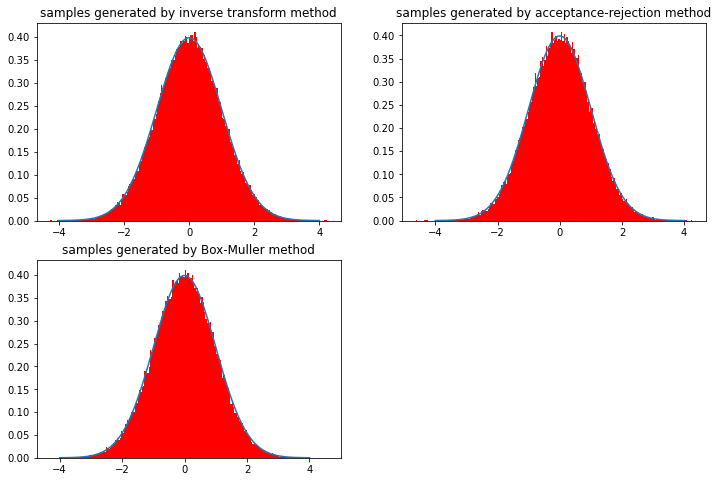

In [12]:
x = np.linspace(-4, 4, 1000)
y = stats.norm.pdf(x)
sample_number = 100000

# plot hist of samples generated by inverse transform method
plt.figure(figsize=(12,8))
plt.subplot(2, 2, 1)
plt.hist(generate_norm_invtrans(sample_number),bins=200,color='red',density=True)
plt.plot(x, y)
plt.title("samples generated by inverse transform method")

# plot hist of samples generated by acceptance-rejection method
plt.subplot(2, 2, 2)
plt.hist(generate_norm_accrej(sample_number),bins=200,color='red',density=True)
plt.plot(x, y)
plt.title("samples generated by acceptance-rejection method")

# plot hist of samples generated by Box-Muller method
plt.subplot(2, 2, 3)
plt.hist(generate_norm_boxmuller(sample_number),bins=200,color='red',density=True)
plt.plot(x, y)
plt.title("samples generated by Box-Muller method")

plt.show()

**3. In all subsequent calculations, fix one choice of your standard normal distribution generator that is considered to be the best. Examine the convergence of the estimates of the option price with respect to the number of sample size $n$. Try with $n = 2500, 5000, 10000, 20000, 40000$ and $80000$. Plot the estimates of option value against $\log n$ and deduce the order of convergence with respect to $n$.**

In [13]:
d = 4
r = 0.02
T = 0.5
sigma = [0.1,0.1,0.1,0.2]
S0 = [45,50,45,55]

M = np.array([[1.0,0.3,-0.2,0.4],
              [0.3,1.0,-0.3,0.1],
              [-0.2,-0.3,1.0,0.5],
              [0.4,0.1,0.5,1.0]])
A = cholesky_decomposition(M)

n_list = [2500,5000,10000,20000,40000,80000]
K_list = [50,55,60]
K_n_est = np.zeros((len(K_list),len(n_list)))
K_n_error = np.zeros((len(K_list),len(n_list)))

print(f'{"":15}{"Estimate":13}{"Standard Error ":18}{"Relative Error"}')
for n_index, n in enumerate(n_list):
    print(f'{n=}')
    for K_index, K in enumerate(K_list):
        # we choose Box-Muller method to generate normal samples
        Y = A @ generate_norm_boxmuller(d*n).reshape((d,n))
        for k in range(d):
            Y[k] = S0[k] * np.exp((r-0.5*sigma[k]**2)*T + sigma[k]*np.sqrt(T)*Y[k])
        H = Y.max(axis=0) - K
        H[H<0] = 0
        H = np.exp(-r*T)*H
        v = np.mean(H)
        se = np.sqrt((np.sum(np.square(H-v))/n/(n-1)))
        re = se/v
        K_n_est[K_index,n_index] = v
        K_n_error[K_index,n_index] = se
        print(f'{K=}{"":12}{v:.4f}{"":10}{se:.4f}{"":12}{re*100:.4f}%')
    print('')

               Estimate     Standard Error    Relative Error
n=2500
K=50            6.8860          0.1280            1.8585%
K=55            3.5241          0.1026            2.9110%
K=60            1.4877          0.0701            4.7098%

n=5000
K=50            6.8368          0.0873            1.2775%
K=55            3.3846          0.0697            2.0598%
K=60            1.5559          0.0501            3.2174%

n=10000
K=50            7.1132          0.0630            0.8852%
K=55            3.3989          0.0499            1.4690%
K=60            1.4938          0.0345            2.3091%

n=20000
K=50            6.9958          0.0442            0.6323%
K=55            3.5107          0.0361            1.0274%
K=60            1.4889          0.0247            1.6559%

n=40000
K=50            7.0081          0.0310            0.4422%
K=55            3.4643          0.0253            0.7303%
K=60            1.5042          0.0176            1.1732%

n=80000
K=50            7.

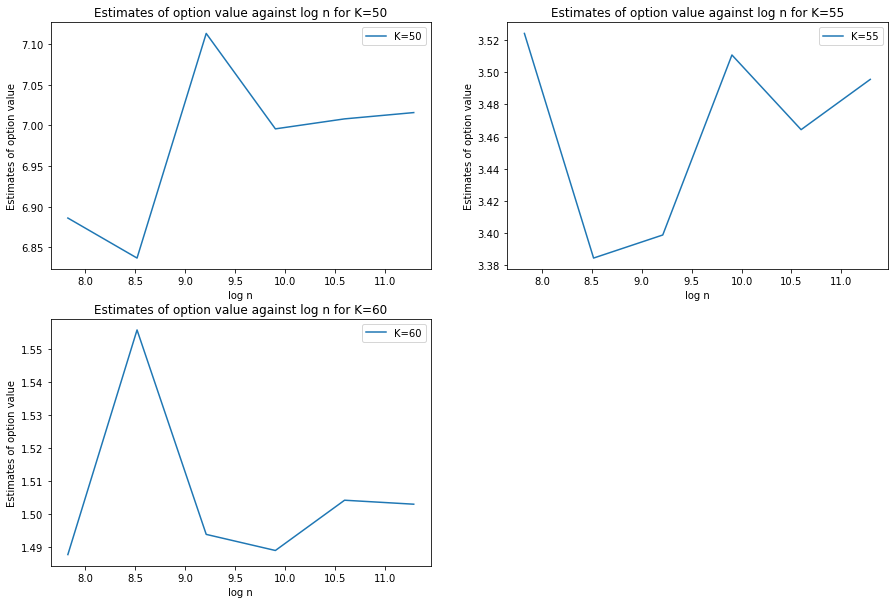

In [14]:
# plot Estimates of option value against log n
plt.figure(figsize=(15,10))
for K_index, K in enumerate(K_list):
    plt.subplot(2, 2, K_index+1)
    plt.plot(np.log(n_list), K_n_est[K_index], label=f"{K=}")
    plt.legend()
    plt.xlabel('log n')
    plt.ylabel('Estimates of option value')
    plt.title(f"Estimates of option value against log n for {K=}")
plt.show()

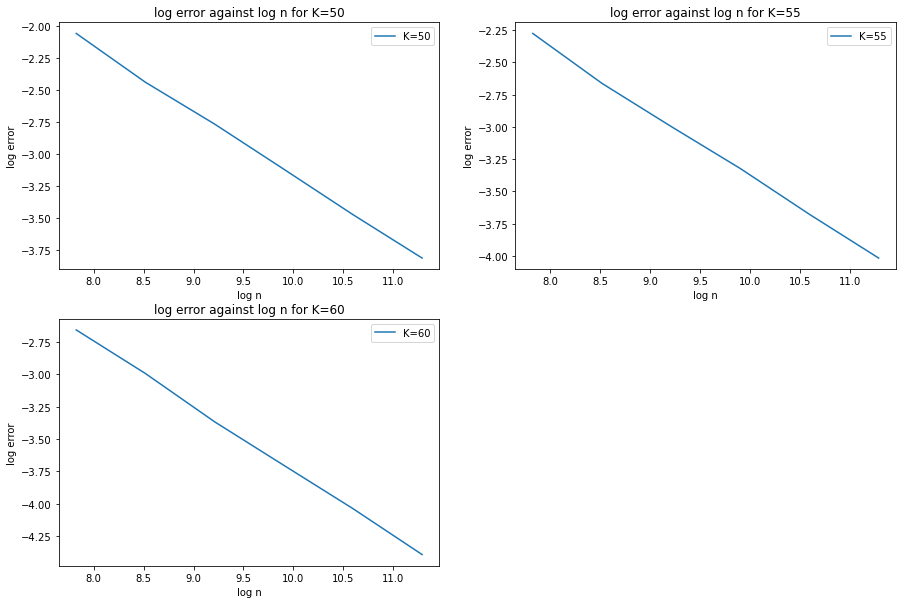

In [15]:
# plot log(error) against log(n) to deduce the order of convergence
plt.figure(figsize=(15,10))
for K_index, K in enumerate(K_list):
    plt.subplot(2, 2, K_index+1)
    plt.plot(np.log(n_list), np.log(K_n_error[K_index]), label=f"{K=}")
    plt.legend()
    plt.xlabel('log n')
    plt.ylabel('log error')
    plt.title(f"log error against log n for {K=}")
plt.show()

In [16]:
# we use linear regression cefficient between log(error) and log(n) for K=50 to estimate rate of convergence
res = stats.linregress(np.log(n_list), np.log(K_n_error[0]))
print("The estimate rate of convergence is: ", res.slope)

The estimate rate of convergence is:  -0.5050164764266293


Thus the rate of convergence is approximately $O(n^{-\frac{1}{2}})$.

**4. Examine the ratio of standard error to estimate (which is known as the empirical relative error) with respect to the strike price $K$. Try $K = 50, 55, 60,..., 80$. Plot the empirical relative error with respect to the strike price.**

In [17]:
d = 4
r = 0.02
T = 0.5
sigma = [0.1,0.1,0.1,0.2]
S0 = [45,50,45,55]
M = np.array([[1.0,0.3,-0.2,0.4],
              [0.3,1.0,-0.3,0.1],
              [-0.2,-0.3,1.0,0.5],
              [0.4,0.1,0.5,1.0]])
A = cholesky_decomposition(M)

n_list = [2500,5000,10000,20000]
K_list = np.linspace(50,80,7)
n_K_est = np.zeros((len(n_list),len(K_list)))

print(f'{"":15}{"Estimate":13}{"Standard Error ":18}{"Relative Error"}')
for n_index, n in enumerate(n_list):
    print(f'{n=}')
    for K_index, K in enumerate(K_list):
        Y = A @ generate_norm_boxmuller(d*n).reshape((d,n))
        for k in range(d):
            Y[k] = S0[k] * np.exp((r-0.5*sigma[k]**2)*T + sigma[k]*np.sqrt(T)*Y[k])
        H = Y.max(axis=0) - K
        H[H<0] = 0
        H = np.exp(-r*T)*H
        v = np.mean(H)
        se = np.sqrt((np.sum(np.square(H-v))/n/(n-1)))
        re = se/v
        n_K_est[n_index,K_index] = re
        print(f'{K=:.0f}{"":12}{v:.4f}{"":10}{se:.4f}{"":12}{re*100:.4f}%')
    print('')

               Estimate     Standard Error    Relative Error
n=2500
K=50            7.1635          0.1298            1.8117%
K=55            3.5155          0.1018            2.8970%
K=60            1.4778          0.0712            4.8211%
K=65            0.5576          0.0446            7.9990%
K=70            0.2030          0.0255            12.5412%
K=75            0.0565          0.0138            24.4139%
K=80            0.0105          0.0045            43.0096%

n=5000
K=50            6.8512          0.0862            1.2589%
K=55            3.3814          0.0714            2.1116%
K=60            1.5527          0.0510            3.2817%
K=65            0.5932          0.0319            5.3701%
K=70            0.1846          0.0171            9.2630%
K=75            0.0520          0.0079            15.2243%
K=80            0.0173          0.0050            28.9196%

n=10000
K=50            7.0665          0.0622            0.8799%
K=55            3.5214          0.0514  

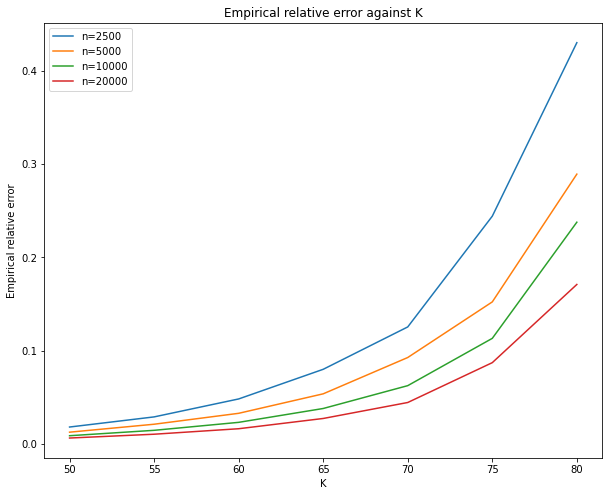

In [18]:
plt.figure(figsize=(10,8))
for n_index, n in enumerate(n_list):
    plt.plot(K_list, n_K_est[n_index], label=f"{n=}")
    
plt.legend()
plt.xlabel('K')
plt.ylabel('Empirical relative error')
plt.title(f"Empirical relative error against K")
plt.show()

**5. Apply the antithetic variate method and examine the impact of this simple variance reduction technique in achieving better convergence.**

In [19]:
d = 4
r = 0.02
T = 0.5
sigma = [0.1,0.1,0.1,0.2]
S0 = [45,50,45,55]
M = np.array([[1.0,0.3,-0.2,0.4],
              [0.3,1.0,-0.3,0.1],
              [-0.2,-0.3,1.0,0.5],
              [0.4,0.1,0.5,1.0]])
A = cholesky_decomposition(M)

n_list = [2500,5000,10000,20000,40000,80000]
K_list = [50,55,60]
K_n_est = np.zeros((len(K_list),len(n_list)))
K_n_error = np.zeros((len(K_list),len(n_list)))
K_n_anti_est = np.zeros((len(K_list),len(n_list)))
K_n_anti_error = np.zeros((len(K_list),len(n_list)))

print('(Note that the number of standard normals genrated in Antithetic Variate is half of that by Orignal M.C.)\n')
print(f'{"":15}{"Estimate":13}{"Standard Error ":18}{"Estimate(AntiVar)":20}{"Standard Error(AntiVar)"}')
for n_index, n in enumerate(n_list):
    print(f'{n=}')
    for K_index, K in enumerate(K_list):
        # we choose Box-Muller method to generate normal samples
        Y = A @ generate_norm_boxmuller(d*n).reshape((d,n))
        # we choose half of n samples using Antithetic Variate method
        Y_anti = np.hstack((Y[:,:int(n/2)], -Y[:,:int(n/2)]))
        for k in range(d):
            Y[k] = S0[k] * np.exp((r-0.5*sigma[k]**2)*T + sigma[k]*np.sqrt(T)*Y[k])
            Y_anti[k] = S0[k] * np.exp((r-0.5*sigma[k]**2)*T + sigma[k]*np.sqrt(T)*Y_anti[k])
        # estimate by original M.C. method
        H = Y.max(axis=0) - K
        H[H<0] = 0
        H = np.exp(-r*T)*H
        v = np.mean(H)
        se = np.sqrt((np.sum(np.square(H-v))/n/(n-1)))
        K_n_est[K_index,n_index] = v
        K_n_error[K_index,n_index] = se
        
        # estimate by Antithetic Variate method
        H = Y_anti.max(axis=0) - K
        H[H<0] = 0
        H = np.exp(-r*T)*H
        v_anti = np.mean(H)
        se_anti = np.sqrt((np.sum(np.square(H-v_anti))/n/(n-1)))
        K_n_anti_est[K_index,n_index] = v_anti
        K_n_anti_error[K_index,n_index] = se_anti
        print(f'{K=}{"":12}{v:.4f}{"":10}{se:.4f}{"":12}{v_anti:.4f}{"":14}{se_anti:.4f}')
    print('')

(Note that the number of standard normals genrated in Antithetic Variate is half of that by Orignal M.C.)

               Estimate     Standard Error    Estimate(AntiVar)   Standard Error(AntiVar)
n=2500
K=50            7.1196          0.1271            7.0263              0.1256
K=55            3.5155          0.1056            3.4451              0.1000
K=60            1.5063          0.0707            1.5350              0.0731

n=5000
K=50            6.9186          0.0877            7.0431              0.0897
K=55            3.4829          0.0715            3.6137              0.0740
K=60            1.5121          0.0494            1.4701              0.0491

n=10000
K=50            7.0353          0.0625            6.9530              0.0614
K=55            3.4377          0.0503            3.4104              0.0502
K=60            1.5011          0.0350            1.5132              0.0353

n=20000
K=50            6.9908          0.0440            7.0259              0.0441


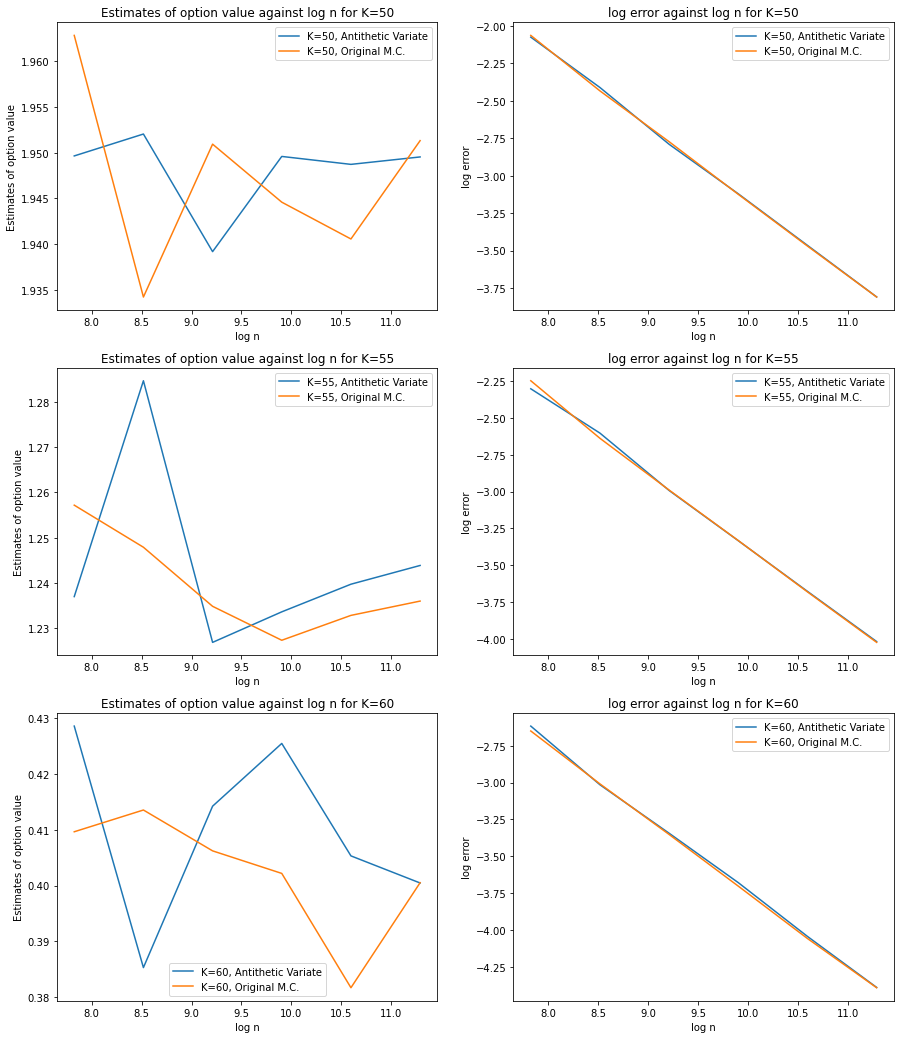

In [20]:
plt.figure(figsize=(15,18))
for K_index, K in enumerate(K_list):
    # plot Estimates of option value against log(n)
    plt.subplot(3, 2, K_index*2+1)
    plt.plot(np.log(n_list), np.log(K_n_anti_est[K_index]), label=f"{K=}, Antithetic Variate")
    plt.plot(np.log(n_list), np.log(K_n_est[K_index]), label=f"{K=}, Original M.C.")
    plt.legend()
    plt.xlabel('log n')
    plt.ylabel('Estimates of option value')
    plt.title(f"Estimates of option value against log n for {K=}")

    # plot log(error) against log(n)
    plt.subplot(3, 2, K_index*2+2)
    plt.plot(np.log(n_list), np.log(K_n_anti_error[K_index]), label=f"{K=}, Antithetic Variate")
    plt.plot(np.log(n_list), np.log(K_n_error[K_index]), label=f"{K=}, Original M.C.")
    plt.legend()
    plt.xlabel('log n')
    plt.ylabel('log error')
    plt.title(f"log error against log n for {K=}")
plt.show()

Remark:

Antithetic Variate Method uses a half of generated standard normals with their negative sequence to simulate the option value. The Standard Error of such implement is very close to that of original Monte Carlo Method using the whole generated standard normals. It reduces a half work to generate random numbers. However, theoretically, the Antithetic Variate Method using a half of generated random numbers should have attained less Standard Error compared to generating the whole. But their Standard Errors are close maybe due to the antitheticaly sampled option value is not so negatively relative to the originally sampled option value.

**6. Bonus: Explore the use of the other more sophisticated sampling method like stratification to achieve better variance reduction.**

We implement stratification in the following way:

1. For $i=1,..., d$ assets, partition the unit interval into $k$ equal length $\left\{[0,\dfrac{1}{k}), [\dfrac{1}{k},\dfrac{2}{k}),..., [\dfrac{k-1}{k},1]\right\} := \mathcal{P}_i$.

2. Then each element $I_j \in \mathcal{P}_1\times\mathcal{P}_2\times ...\times\mathcal{P}_d$ can be defined to be a stratum. The strata have cardinality $k^d$.

3. For each simulation, for each stratum j, the vector of uniform random numbers is generated by $U(I_j)$.

4. The vector of standard normals is transformed by $\Phi^{-1}(U(I_j))$ using inverse tansform method. (To keep less variance in each interval since monotone of inverse c.d.f.)

5. The rest are standard process of stratification.

At the following experiment, we set $k=5$. Thus we have $k^d=5^4=625$ strata.

In [21]:
@numba.jit(nopython=True) 
def generate_strata(n, d, k):
    """
    Generate numpy array of intervals' left value of strata.
    :param n: number of generated samples
    :param d: dimension of generated samples
    :param k: number of intervals of strata
    :return: (d, n) shape numpy array of intervals' left value of strata
    """
    # c is the number of strata
    c = k ** d
    # m is the number of samples in each stratum
    m = int(n/c)
    strata = np.zeros((d,m*c))
    for i in range(d):
        for j in range(c):
            strata[i,j*m:(j+1)*m] = np.floor((j % (k ** (i+1)))/ (k ** i)) / k
    
    return strata

In [22]:
# an example of generate_strata()
# number of strata is 625, each stratum has one sample
# show top 16 columns
print(generate_strata(625, 4, 5)[:,:16])

[[0.  0.2 0.4 0.6 0.8 0.  0.2 0.4 0.6 0.8 0.  0.2 0.4 0.6 0.8 0. ]
 [0.  0.  0.  0.  0.  0.2 0.2 0.2 0.2 0.2 0.4 0.4 0.4 0.4 0.4 0.6]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]


In [23]:
def generate_norm_invtrans_strata(strata, k):
    """
    Generate the standard normal distribution of strata using inverse transform method.
    :param strata: (d, n) shape numpy array of intervals' left value of strata
    :param k: number of intervals of strata
    :return: (d, n) shape numpy array of generated samples
    """
    d, n = strata.shape
    return ndtri(strata + np.random.rand(d, n)/k)

In [24]:
d = 4
r = 0.02
T = 0.5
sigma = [0.1,0.1,0.1,0.2]
S0 = [45,50,45,55]
M = np.array([[1.0,0.3,-0.2,0.4],
              [0.3,1.0,-0.3,0.1],
              [-0.2,-0.3,1.0,0.5],
              [0.4,0.1,0.5,1.0]])
A = cholesky_decomposition(M)

n_list = [2500,5000,10000,20000,40000,80000]
K_list = [50,55,60]
K_n_est = np.zeros((len(K_list),len(n_list)))
K_n_error = np.zeros((len(K_list),len(n_list)))
K_n_strat_est = np.zeros((len(K_list),len(n_list)))
K_n_strat_error = np.zeros((len(K_list),len(n_list)))
k = 5

print(f'Orignal M.C. vs Stratification({k=} intervals)\n')
print(f'{"":15}{"Estimate":13}{"Standard Error ":18}{"Estimate(Strat)":20}{"Standard Error(Strat)"}')
for n_index, n in enumerate(n_list):
    print(f'{n=}')
    for K_index, K in enumerate(K_list):
        # we choose Box-Muller method to generate normal samples
        Y = A @ generate_norm_boxmuller(d*n).reshape((d,n))
        # we choose half of n samples using Antithetic Variate method
        Y_strat = generate_strata(n, d, k)
        Y_strat = A @ generate_norm_invtrans_strata(Y_strat, k)
        for k in range(d):
            Y[k] = S0[k] * np.exp((r-0.5*sigma[k]**2)*T + sigma[k]*np.sqrt(T)*Y[k])
            Y_strat[k] = S0[k] * np.exp((r-0.5*sigma[k]**2)*T + sigma[k]*np.sqrt(T)*Y_strat[k])
        # estimate by original M.C. method
        H = Y.max(axis=0) - K
        H[H<0] = 0
        H = np.exp(-r*T)*H
        v = np.mean(H)
        se = np.sqrt((np.sum(np.square(H-v))/n/(n-1)))
        K_n_est[K_index,n_index] = v
        K_n_error[K_index,n_index] = se
        
        # estimate by Antithetic Variate method
        H = Y_strat.max(axis=0) - K
        H[H<0] = 0
        H = np.exp(-r*T)*H
        v_strat = np.mean(H)
        se_strat = np.sqrt((np.sum(np.square(H-v_strat))/n/(n-1)))
        K_n_strat_est[K_index,n_index] = v_strat
        K_n_strat_error[K_index,n_index] = se_strat
        print(f'{K=}{"":12}{v:.4f}{"":10}{se:.4f}{"":12}{v_strat:.4f}{"":14}{se_strat:.4f}')
    print('')

Orignal M.C. vs Stratification(k=5 intervals)

               Estimate     Standard Error    Estimate(Strat)     Standard Error(Strat)
n=2500
K=50            7.1383          0.1205            6.9392              0.1235
K=55            3.5040          0.1042            3.4196              0.0996
K=60            1.5551          0.0732            1.5300              0.0696

n=5000
K=50            7.1586          0.0895            7.0117              0.0878
K=55            3.5752          0.0738            3.4229              0.0698
K=60            1.4767          0.0488            1.4708              0.0491

n=10000
K=50            7.0996          0.0635            7.0508              0.0624
K=55            3.4415          0.0508            3.4781              0.0509
K=60            1.4510          0.0338            1.4807              0.0345

n=20000
K=50            7.0216          0.0444            7.0398              0.0444
K=55            3.5285          0.0365            3.4528      

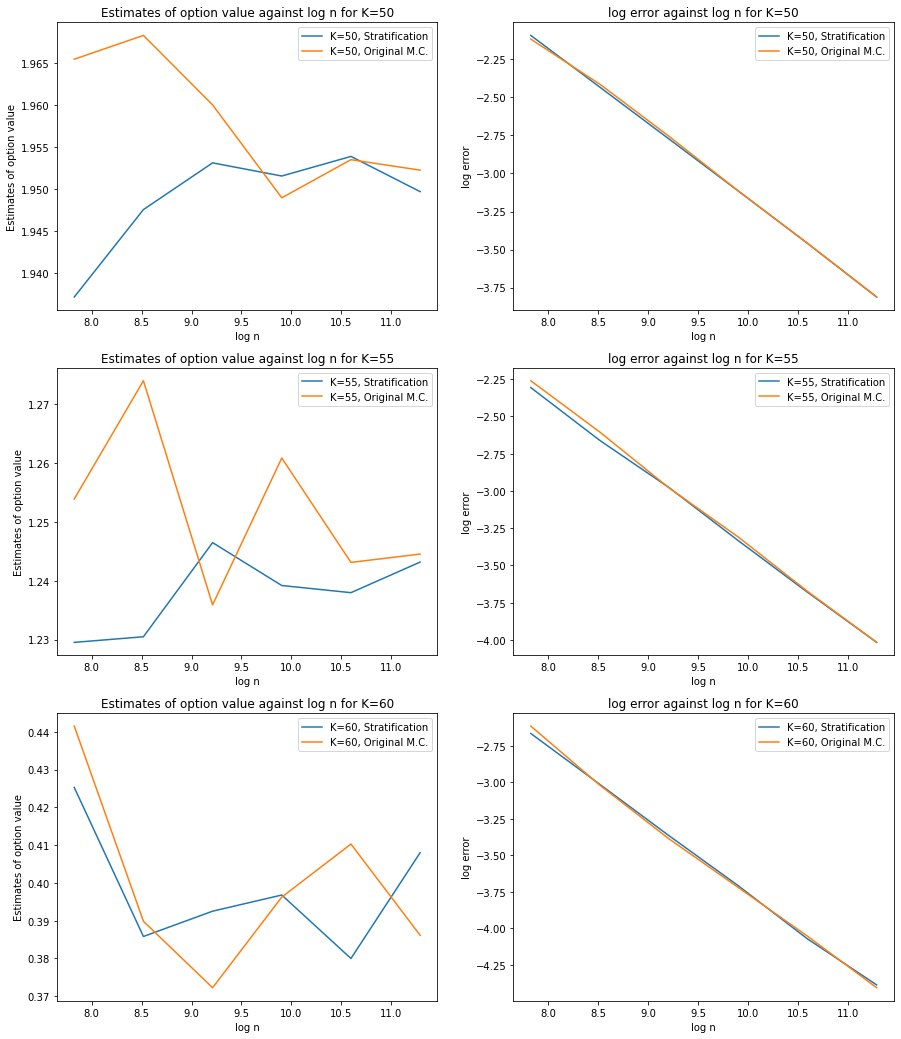

In [25]:
plt.figure(figsize=(15,18))
for K_index, K in enumerate(K_list):
    # plot Estimates of option value against log(n)
    plt.subplot(3, 2, K_index*2+1)
    plt.plot(np.log(n_list), np.log(K_n_strat_est[K_index]), label=f"{K=}, Stratification")
    plt.plot(np.log(n_list), np.log(K_n_est[K_index]), label=f"{K=}, Original M.C.")
    plt.legend()
    plt.xlabel('log n')
    plt.ylabel('Estimates of option value')
    plt.title(f"Estimates of option value against log n for {K=}")

    # plot log(error) against log(n)
    plt.subplot(3, 2, K_index*2+2)
    plt.plot(np.log(n_list), np.log(K_n_strat_error[K_index]), label=f"{K=}, Stratification")
    plt.plot(np.log(n_list), np.log(K_n_error[K_index]), label=f"{K=}, Original M.C.")
    plt.legend()
    plt.xlabel('log n')
    plt.ylabel('log error')
    plt.title(f"log error against log n for {K=}")
plt.show()

Remark:

At this scenario, Stratification gives a simliar error compared with the original M.C. method, maybe better when n is not large.